In [3]:
!pip install diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.6 MB/s eta 0:00:0000:0100:01m
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 36.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00
  Using cached regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 54.1 MB/s eta 0:00:00
  Using cached pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached aiohttp-3.8.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 65.4 MB

https://huggingface.co/settings/tokens

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [1]:
import os
import random

import numpy as np
import torch


def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)
    
random_state = 42    
seed_everything(random_state)

# Utils

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im
    


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

In [3]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("leffff/south-park-character-png-dataset-old", split="train")


IMAGE_SIZE = 32
BATCH_SIZE = 64

preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True
)

Resolving data files:   0%|          | 0/906 [00:00<?, ?it/s]

X shape: torch.Size([8, 3, 32, 32])


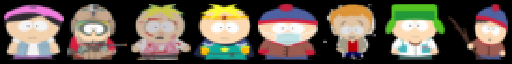

In [4]:
x_batch = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", x_batch.shape)
show_images(x_batch).resize((8 * 64, 64), resample=Image.NEAREST)

In [5]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

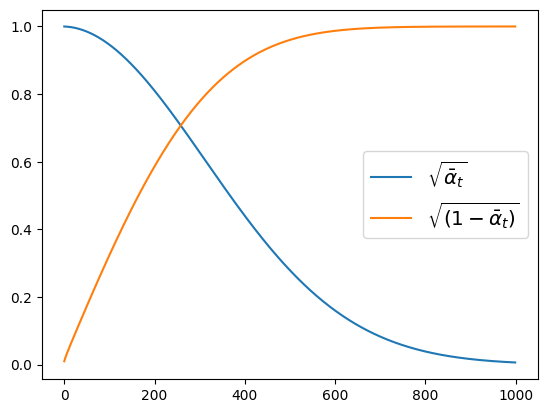

In [6]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 3, 32, 32])


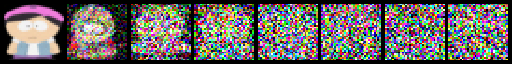

In [7]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(x_batch)
noisy_x_batch = noise_scheduler.add_noise(x_batch, noise, timesteps)
print("Noisy X shape", noisy_x_batch.shape)
show_images(noisy_x_batch).resize((8 * 64, 64), resample=Image.NEAREST)

# Model

In [8]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    ),
)
model.to(device);

# Let's Trains

In [9]:
from diffusers import DDPMPipeline
from tqdm.auto import tqdm 

noise_scheduler = DDPMScheduler(
    num_train_timesteps=300, 
    beta_schedule="squaredcos_cap_v2"
)

noise_scheduler.set_timesteps(num_inference_steps=300)

noise_scheduler.timesteps

tensor([299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286,
        285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272,
        271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258,
        257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244,
        243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230,
        229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216,
        215, 214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202,
        201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188,
        187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174,
        173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160,
        159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146,
        145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132,
        131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 1

In [10]:
noise_scheduler.num_inference_steps, noise_scheduler.num_train_timesteps

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


(300, 300)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:10, loss: 0.15204028338193892


  0%|          | 0/300 [00:00<?, ?it/s]

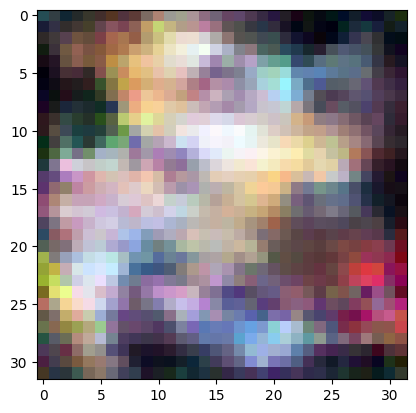

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:20, loss: 0.12598683536052704


  0%|          | 0/300 [00:00<?, ?it/s]

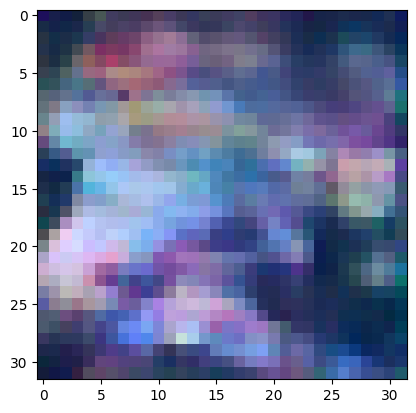

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:30, loss: 0.09606958776712418


  0%|          | 0/300 [00:00<?, ?it/s]

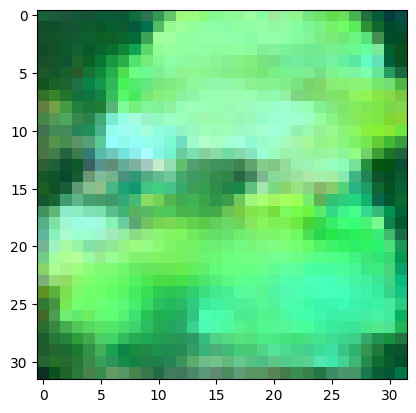

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:40, loss: 0.09409175763527552


  0%|          | 0/300 [00:00<?, ?it/s]

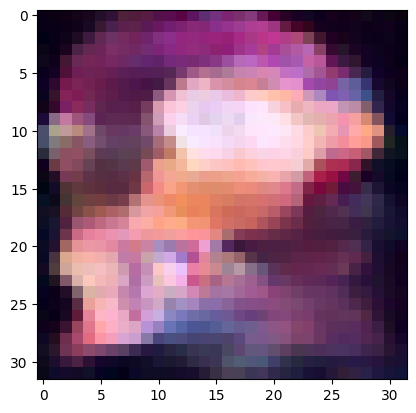

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:50, loss: 0.0941964199145635


  0%|          | 0/300 [00:00<?, ?it/s]

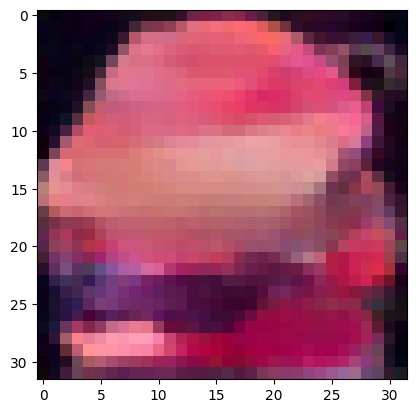

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:60, loss: 0.08620047469933828


  0%|          | 0/300 [00:00<?, ?it/s]

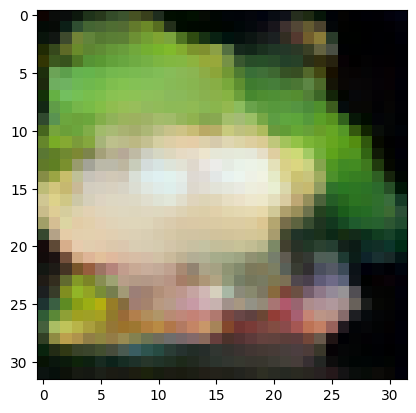

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:70, loss: 0.08156419470906258


  0%|          | 0/300 [00:00<?, ?it/s]

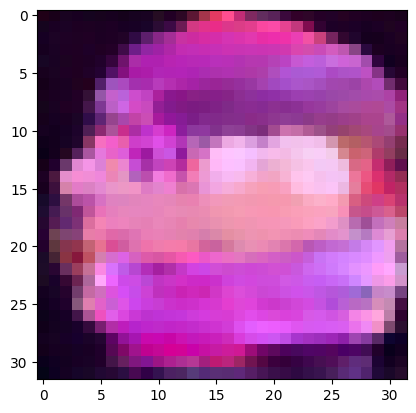

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:80, loss: 0.07489687328537305


  0%|          | 0/300 [00:00<?, ?it/s]

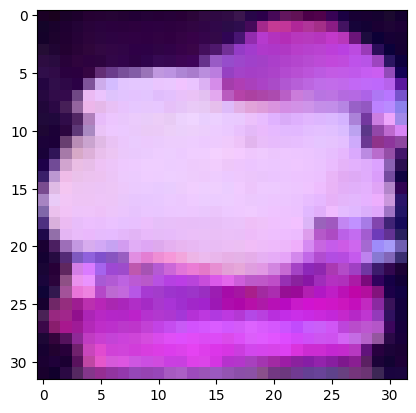

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:90, loss: 0.07290363063414891


  0%|          | 0/300 [00:00<?, ?it/s]

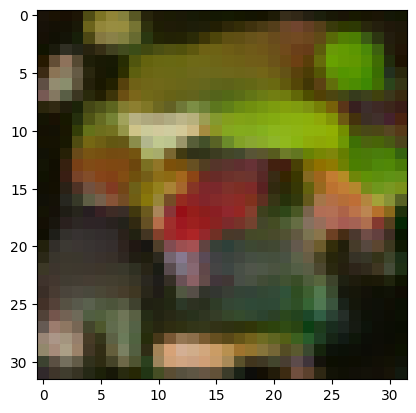

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:100, loss: 0.0677327886223793


  0%|          | 0/300 [00:00<?, ?it/s]

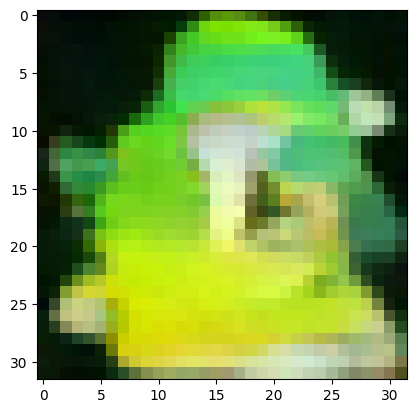

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(100):
    for batch in tqdm(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()
        
    if (epoch + 1) % 10 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch + 1}, loss: {loss_last_epoch}")

        image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
        pipeline_output = image_pipe(num_inference_steps=300)
        plt.imshow(pipeline_output.images[0])
        plt.show()

# Let's sample

In [12]:
from diffusers import DDPMPipeline
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [13]:
noise_scheduler.timesteps

tensor([299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286,
        285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273, 272,
        271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 259, 258,
        257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247, 246, 245, 244,
        243, 242, 241, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230,
        229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216,
        215, 214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202,
        201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188,
        187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174,
        173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160,
        159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146,
        145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132,
        131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 1

  0%|          | 0/300 [00:00<?, ?it/s]

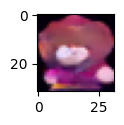

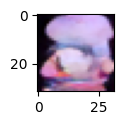

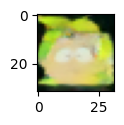

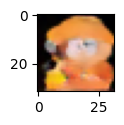

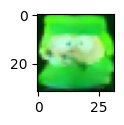

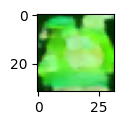

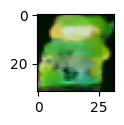

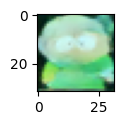

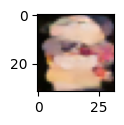

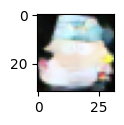

In [16]:
pipeline_output = image_pipe(batch_size=10, num_inference_steps=300)
for image in pipeline_output.images:
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.show()

# Color Guidance

In [17]:
def color_loss(images, target_color=(0.1, 0.9, 0.1)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

0it [00:00, ?it/s]

0 loss: 33.5853271484375
2 loss: 33.33501434326172
4 loss: 33.33590316772461
6 loss: 33.279930114746094
8 loss: 33.360382080078125
10 loss: 33.39481735229492
12 loss: 33.37981033325195
14 loss: 33.3779296875
16 loss: 33.406044006347656
18 loss: 33.39542007446289
20 loss: 33.39876174926758
22 loss: 33.39045333862305
24 loss: 33.410640716552734
26 loss: 33.42510986328125
28 loss: 33.42856216430664
30 loss: 33.44343948364258
32 loss: 33.449825286865234
34 loss: 33.454917907714844
36 loss: 33.45382308959961
38 loss: 33.44879913330078


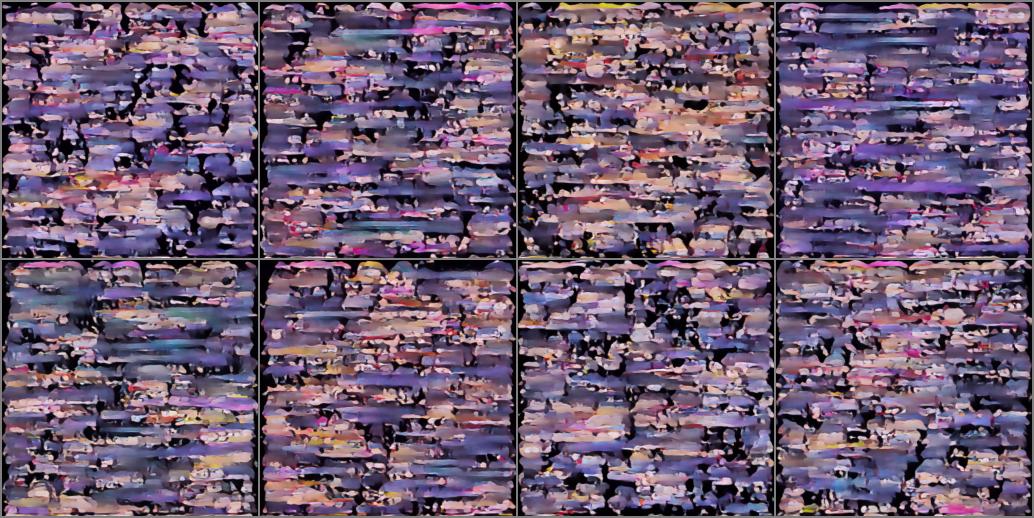

In [18]:
noise_scheduler.set_timesteps(num_inference_steps=40)

guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Prepare the model input
    model_input = noise_scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = noise_scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 2 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = noise_scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))